# Tutorial - FRET assisted modeling Pipeline (FAMP)

Welcome to the FAMP tutorial. This notebook demonstrates the use of individual functions within the FAMP pipeline. In this tutorial, a simple RNA hairpin will be modeled, simulated, and FRET predicted using the Modeling, Simulation, and Data Analysis modules.

Requiered and preinstalled software:
- <a href="https://pymol.org/2/" target="_blank">Pymol</a>
- <a href="https://github.com/RNA-FRETools/fretlabel" target="_blank">FRETlabel</a> and <a href="https://github.com/RNA-FRETools/fretraj" target="_blank">FRETtraj</a> 
- <a href="https://www.tbi.univie.ac.at/RNA/RNAfold.1.html" target="_blank">RNAfold</a>
- <a href="https://manual.gromacs.org/" target="_blank">GROMACS</a>
- <a href="https://new.rosettacommons.org/demos/latest/tutorials/install_build/install_build" target="_blank">Rosetta </a>

For the application here, PyMOL, FRETlabel and FRETraj should be installed in the same environment and the plugins should be integrated into PyMOL beforehand. 

Note: Descriptions of parameters and the general process for FRET-assisted modeling are available in the documentation for this program.

To demonstrate the pipeline we will model an RNA haripin, label it in silico, perform MD simulation and evaluate the simulation. 
The dyes will be attached to the base 14 (uracil) and the 3'-end


The sequence of the Hairpin:
```
>RNA_Hairpin sequence
caauauuuauuaauaucuuccggauauuaauaaauauug
```
<img src="images/rna_hairpin.png" width="500"/>


In [2]:
import os

import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import famp
import lmfit
import pandas as pd
import subprocess
import fretraj as ft
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import numpy as np

current_dir = os.getcwd()
print(current_dir)

/Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial


## Part 1: *de novo* modeling

Modeling capabilities within the pipeline program are restricted to *de novo* modeling, utilizing two external programs. Secondary structure prediction is performed using the RNA Fold program, while Rosetta is employed for tertiary structure prediction.

All functionalities are encapsulated within the Modeling class. The class is instantiated by making a class call and specifying the following attributes:

- `working_dir` = directory in which the results are to be saved
- `file_path_sequence` = path to the input fasta sequence
- `modeling_parameter` = Python dictiononary with the defined modeling parameters (see parameters)

In [3]:
rosetta_parameter = {
    "path_to_rosetta": "rna_denovo.default.linuxgccrelease",
    "nstruct": 5,
    "minimize_rna": True,
    "cycles": 10000,
    "overwrite": True,
}

modeling_hairpin = famp.modeling.Modeling(working_dir=f"{current_dir}",
                    file_path_sequence=f"{current_dir}/input_data/RNA_Hairpin.fasta",
                    modeling_parameter=rosetta_parameter)

Read in Sequence: >RNA_Hairpin sequence



In [4]:
print(modeling_hairpin.sequence)

caauauuuauuaauaucuuccggauauuaauaaauauug



### Secondary structure prediction 
The secondary structure prediction is carried out using RNAFold. The results are stored in the *secondary_prediction* folder. The results are stored in dot-bracket format within the *dot_bracked.sectstruct* file. Since RNAFold was not designed to predict pseudoknots, these can be included in the file if necessary.
The dot-bracket format: The round brackets "()" stand for standart Watson and Crick base parings in the secondary Structure. Not paired bases are represented by dots ".". Pseudoknots can be represented as square brackets "[]".

In [5]:
modeling_hairpin.predict_2d_structure()

Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/secondary_prediction
2 caauauuuauuaauaucuuccggauauuaauaaauauug

1 ((((((((((((((((((...)))))))))))))))))) (-15.90)



### Tertiary structure prediction
Now we use the 2D structure and Rosetta to predict the 3D structure of the RNA. The function `predict_3d_structure()` is used for this. We pass the previously created secondary structure as an input parameter. A file with the extension "sectstruct" was created in the results of the secondary structure prediction. This file shall be used as input.

In [6]:
modeling_hairpin.predict_3d_structure(f"{os.getcwd()}/secondary_prediction/dot_bracket.secstruct")

Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/rosetta_results
Status : FAIL 127 /bin/sh: rna_denovo.default.linuxgccrelease: command not found



To transfer the structures into the PDB file format after successful modeling, we use the `extract_pdb()` function. Since more than one structure is usually predicted, the number of structures that should be extracted is specified as a parameter.  

In [8]:
modeling_hairpin.extract_pdb(10)

We can now also view the structure(s) with Pymol. The command opens PyMOL and loads the modeled structure. To end the sub-process, PyMOL can simply be closed again. 
The in silico labeling can be done using the FRETlabel GUI. Instructions for labeling can be found here: <a href="https://rna-fretools.github.io/fretlabel/getting_started/pymol_plugin.html" target="_blank"> FRETlabel manual</a>.

Here the first structure was labeled with sCy3 at position 14 and sCy5 at the 3'end. The structure was saved under `input_data/Labeled_RNA_Hairpin.pdb`.




In [19]:
subprocess.run(["pymol", f"{current_dir}/rosetta_results/silent_out.pdb"])

CompletedProcess(args=['pymol', '/home/felix/PycharmProjects/FAMP_rna/tutorial/rosetta_results/silent_out.pdb'], returncode=0)

## part 2: MD Simulation

Movement of the RNA and dyes is simulated in the pipeline using MD simulations. 
The GROMACS program is addressed here. MD simulations can be executed with a simple parameter definition. 
The implementation of restraints between atoms is also implemented. 

The functions are implemented in the `MDSimulation` class. An object is defined by calling the class and defining the following class attributes.
- `working_dir`: Folder in which the results are to be saved
- `file_path_input`: Path to the input structure (*.pdb*) for the MD simulation
- `md_parameter`: Python dictionary with the defined parameters


In [7]:
simulation_parameter = {
    "simulation_name": "MD_Simulation_RNA_Hairpin_showcase",
    "c_magnesium_ions[mol/l]": 0.00,
    "simulation_time[ns]": 100,
    "temperature[°C]": 25,
    "dist_to_box[nm]": "1",
    "water_model": "tip3p",
    "distance_restraints": False
}

simulaiton_haipin = famp.simulation.MDSimulation(working_dir=f"{current_dir}", 
                                                 file_path_input=f"{current_dir}/input_data/Labeled_RNA_Hairpin.pdb", 
                                                 md_parameter=simulation_parameter)


The specified folder exists.


First, the MD simulation must be prepared in the specified working directory. The prepare_new_md_run() function is used to copy the required parameter files and the specified input structure to the "MD_Simulation_RNA_Hairpin_showcase" directory. The directory is created first and is named after the parameter `simulation_name`. 

In [8]:
simulaiton_haipin.prepare_new_md_run()

MD run already exists. To make a new Simulation change the Name or the Simulation in the MD parameter
Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase


### Solvation
In the first step of the MD simulation with GROMACS, the molecule is virtually dissolved in water. Water and ions are generated based on the defined parameters.

In [22]:
simulaiton_haipin.solvate_molecule()

Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/em. Results can be found there
Output: 
                     :-) GROMACS - gmx pdb2gmx, 2020.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman

### MD run
The `run_simulation_steps()` function is used to set the temperature and pressure in the system and then start the actual simulation run. The time to be simulated is defined in the parameters. 
Hint: To see how long the simulation is still running, simply look into the console with which Jupyter-lab was started. Otherwise, all outputs from GROMACS are written to the notebook as soon as the process is completed. In the case of a long simulation, the process ends after a few days and the current remaining simulation time is displayed only in the console. 


In [6]:
simulaiton_haipin.run_simulation_steps()

Results can be found in: /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/nvt
Output: 
                      :-) GROMACS - gmx grompp, 2020.4 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolain

# Part 3: Data Analysis
Nach der MD Simulation müssen die Dateien verarbeitet werden um die Informationen für die FRET Simulation zu erhalten. Dabei müssen vorallen Distanzen zwischen den Farbstoffen bestimmt werden. Dies kann aus expliziten Farbstoffsimulaitonen (MD_dye) oder aus der Berechnung von multiplen ACV entlang der MD Trajektorie bestimmt werden. In diesem Tutorial werden aus einer expliziten Farbstoffsimulation sowohl die expliziten Farbstoffe als auch die MACV betrachtet und ausgewertet. 

Auch für die Datenauswertung wurde eine Klasse definiert: `famp.data_analysis.DataAnalysis()`
Die zu dfinierenden Attribute: 
- `working_dir`: directory in which the results are to be saved. (Should be the same path as the other classes)
- `path_sim_results`: directory where the simulation was saved.
- `analysis_parameter`: Parameter for the analysis class.
- `macv_label_pars`: Patameters for the calculation of ACV and identifaction of the dyes.  

In [9]:
# Parameter for the analysis class and data handling
analysis_paras = {
    "simulation_name": "MD_Simulation_RNA_Hairpin_showcase",
    "input_structure_name": "Labeled_RNA_Hairpin",
    "Donor_residue_name_number": ("C3W", 14),
    "Acceptor_residue_name_number": ("C5W", 39),
}

# reduced version of dye parameters for ACV calculation with FRETraj
dye_acv_parameter = {
    "Acceptor": {
        "name": "sCy5",
        "linker_length": 20,
        "linker_width": 3.5,
        "dye_radius1": 9.5,
        "dye_radius2": 3,
        "dye_radius3": 1.5,
        "cv_fraction": 0.15,
        "cv_thickness": 3
    },
    "Donor": {
        "name": "sCy3",
        "linker_length": 20,
        "linker_width": 3.5,
        "dye_radius1": 8.0,
        "dye_radius2": 3,
        "dye_radius3": 1.5,
        "cv_fraction": 0.15,
        "cv_thickness": 3,
    },
    "Distance": {"sCy3-sCy5":
                     {"R0": 54,
                      "n_dist": 10 ** 6}
                 }

}



analysis_hairpin = famp.data_analysis.DataAnalysis(working_dir=f"{current_dir}",
                                                   path_sim_results=f"{current_dir}/MD_Simulation_RNA_Hairpin_showcase",
                                                   analysis_parameter=analysis_paras, 
                                                   macv_label_pars=dye_acv_parameter)

Cannot find the file /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/md0/Labeled_RNA_Hairpin.gro or /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/md0/Labeled_RNA_Hairpin.xtc.Please make sure that the paths and inputsrtructure name are correct.
C5W
C3W


In [10]:
print(analysis_hairpin.path_sim_results)

/Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase


## Organization
In the first step of the analysis, we will prepare the evaluation with the function `make_data_analysis_results_dirs()`. A new folder *analysis* is created. In addition, the required files are copied into the new folder and the trajectory is converted. Converting larger MD files may take some time. You can view the current progress in the console. 

In [10]:
analysis_hairpin.make_data_analysis_results_dirs()

Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis. Results can be found there
Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis/raw. Results can be found there
Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis/Images. Results can be found there
Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis/Index_Files. Results can be found there
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Select group for output
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Select group for output


To export a PDB trajectory, you can use the function `export_pdb_trajectory()`. The GROMACS module <a href="https://manual.gromacs.org/current/onlinehelp/gmx-trjconv.html" target="_blank">*trajconv*</a> is used to export the trajectory. The parameter `timestep` specifies the flag dt for *trajconv*. It defines in which time steps the structures have to be exported. The larger the number, the fewer structures are exported.

In [11]:
analysis_hairpin.export_pdb_trajectory(100)

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Select group for output


### Explicit dye simulation
If a dye simulation was performed, the function `generate_r_kappa_from_dyes()` can be used to determine distances $R_{DA}$ and $\kappa^{2}$ between the dyes. An R_kappa.dat file is created as well as the coordinates of the dye dipoles are stored in files. These files are required later for the burst simulation in FRETraj. The dyes are defined using the simulation parameters and the function automatically search for the IDs and perform the calculations. All results are stored under `analysis/explicit_dyes`.

In [11]:
analysis_hairpin.generate_r_kappa_from_dyes()

Results can be found in: /Users/felixerichson/Documents/Arbeit_LHM/Programming/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis/explicit_dyes


/Users/felixerichson/anaconda3/envs/famp_test_env/lib/python3.13/site-packages/MDAnalysis/coordinates/XDR.py:253: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn(


Donor ID:
central c: 419
dipole: (448, 425)
Acceptor ID:
central c: 1251
dipole: (1281, 1258)
2001
2001
2001


### MACV calculation

The function `genarate_rkappa_file_from_macv()` is used to generate the R_kappa.dat file from the MACV. First, the ACVs are calculated along the MD trajectory. The dyes are defined via the `dye_acv_paramter` for the ACV. The labeling position is determined automatically based on the other parameters. This is limited to C5 atoms of the uracil with internal labeling. And 3' or 5' labeling. Following the MACV calculation, the necessary information is processed to generate an R_kappa file. The ACV calculations are saved as `.pkl` files and can also be reloaded. All results are stored under `analysis/macv`.

In [14]:
analysis_hairpin.genarate_rkappa_file_from_macv()

Successfully created the directory /home/felix/PycharmProjects/FAMP_rna/tutorial/MD_Simulation_RNA_Hairpin_showcase/analysis/macv. Results can be found there
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Select group for output
Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Select group for output
Attechmentpoint for 14 C3W: 424, C5
Attechmentpoint for 39 C5W: 1186, O3'
[2001, 1]
sCy3-14-C5 sCy5-39-O3' sCy3-sCy5
Empty Accessible volume at position 424. Is your attachment point buried?
One accessible volume is empty
Empty Accessible volume at position 424. Is your attachment point buried?
One accessible volume is empty
Empty Accessible volume at position 424. Is your attachment point buried?
One accessible volume is empty
Empty Accessible volume at position 424. Is your attachment point buried?
One accessible volume is empty
Empty Accessible 

# Step 4: Burst calculation and visualizations
Once the R_kappa.dat files are generated, FRETraj's burst module can be used to simulate the FRET distributions. This can be done for the explicit dyes as well as for the MACVs.
Parameters that need to be defined are listed here. Descriptions of the parameters can be found <a href="https://rna-fretools.github.io/fretraj/background/parameter_file.html#burst-simulation" target="_blank">here</a>. However, the parameters have been extended by etaA and etaD. This describes the detector efficiency of the experimental setup. This parameter must be determined experimentally, like the quantum yield and the lifetime of the dyes. Here we simulate a perfect experiment by assuming that quantum yield and detector efficiency are 100%.

In [12]:
burst_parameter = {
    "dyes": {
        "tauD": 1.4,
        "tauA": 1.12,
        "QD": 1,
        "QA": 1,
        "etaA":1,
        "etaD":1,
        "dipole_angle_abs_em": 10
    },
    "sampling": {
        "nbursts": 20000,
        "skipframesatstart": 0,
        "skipframesatend": 0,
        "multiprocessing": True
    },
    "fret": {
        "R0": 5.4,
        "kappasquare": 0.6666,
        "gamma": True,
        "quenching_radius": 1
    },
    "species": {
        "name": ["all"],
        "unix_pattern_rkappa": ["*.dat"],
        "unix_pattern_don_coords": ["*Donor*.txt"],
        "unix_pattern_acc_coords": ["*Acceptor*.txt"],
        "probability": [1],
        "n_trajectory_splits": None
    },
    "bursts": {
        "lower_limit": 40,
        "upper_limit": 120,
        "lambda": -2.3,
        "QY_correction": False,
        "averaging": "all",
        "burst_size_file": None
    }
}

You can now use FRETraj, the generated r-kappa.dat files and the parameters to simulate a FRET distribution. The FAMP analysis already includes the relevant files. The directory in which the rkappa.dat files of the corresponding calculation are located and the defined parameters must be transferred to the burst experiment. If explicit dyes have been simulated, the anisotropy can also be calculated.

In [13]:
burst_explicit_dyes = ft.burst.Experiment(f"{current_dir}/MD_Simulation_RNA_Hairpin_showcase/analysis/explicit_dyes/", parameters=burst_parameter, compute_anisotropy=True)
burst_macv = ft.burst.Experiment(f"{current_dir}/MD_Simulation_RNA_Hairpin_showcase/analysis/macv/", parameters=burst_parameter)

Loading files...
Orientation independent R0_const = 5.8 A

              donor    acceptor
QY            1.00    1.00
tau (ns)      1.40    1.12
k_f (ns^-1)   0.71    0.89
k_ic (ns^-1)  0.00    0.00
              
Burst averaging method: all
Calculate anisotropy: yes



Calculating bursts:   0%|          | 0/20000 [? s]

Combining burst...


average FRET efficiency: 0.24 +- 0.06

Loading files...
Orientation independent R0_const = 5.8 A

              donor    acceptor
QY            1.00    1.00
tau (ns)      1.40    1.12
k_f (ns^-1)   0.71    0.89
k_ic (ns^-1)  0.00    0.00
              
Burst averaging method: all
Calculate anisotropy: no



Calculating bursts:   0%|          | 0/20000 [? s]

Combining burst...


average FRET efficiency: 0.43 +- 0.06



# Visualizations
Now we have everything we need to visualize and evaluate the data.
First, we will analyze the trajectory by calculating the RMSD along the trajectory. 

In [14]:
def rgb_to_hex(rgb):
    r, g, b = rgb
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)

In [15]:
aligning_traj = mda.Universe("MD_Simulation_RNA_Hairpin_showcase/analysis/raw/Labeled_RNA_Hairpin_unlabeled_s1.pdb",
                             "MD_Simulation_RNA_Hairpin_showcase/analysis/raw/Labeled_RNA_Hairpin_unlabeled.xtc")
pdb_reference = mda.Universe("MD_Simulation_RNA_Hairpin_showcase/analysis/raw/Labeled_RNA_Hairpin_unlabeled_s1.pdb")

In [16]:
RMSD = rms.RMSD(aligning_traj,
                pdb_reference)
RMSD.run()

In [17]:
rmsd_df = pd.DataFrame(RMSD.results.rmsd, columns=["Frame","Time [ps]","RMSD"])
rmsd_df

,Frame,Time [ps],RMSD
0,0.0,0.0,1.026018
1,1.0,10.0,0.000005
2,2.0,20.0,1.356871
3,3.0,30.0,1.631982
4,4.0,40.0,1.996802
...,...,...,...
1996,1996.0,19960.0,4.296591
1997,1997.0,19970.0,4.277737
1998,1998.0,19980.0,4.500997
1999,1999.0,19990.0,3.928430


<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
/var/folders/zf/wpmcnbjn53lgn5jk3smt4cv80000gn/T/ipykernel_90582/2542311387.py:6: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel("RMSD ($\mathregular{\AA}$)", fontsize=14)


mean RMSD hairpin simulaiton: 4.315090018173057 +- 0.9140790000955157


(0.0, 8.0)

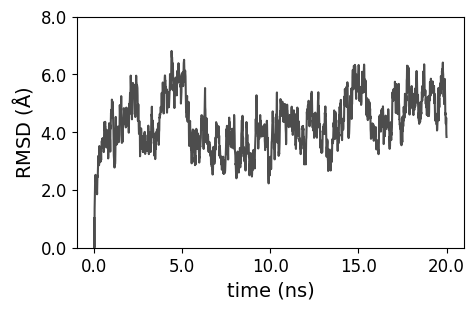

In [18]:
print(f"mean RMSD hairpin simulaiton: {rmsd_df['RMSD'].mean()} +- {rmsd_df['RMSD'].std()}")

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
ax.plot(rmsd_df['Time [ps]']/1000, rmsd_df['RMSD'], color="#4d4d4d")
ax.set_xlabel("time (ns)", fontsize=14)
ax.set_ylabel("RMSD ($\mathregular{\AA}$)", fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', labelsize=12)
ax.set_ylim(0,8)

### FRET Distributions
With the calculated burts we can visualize and compare the FRET distributions of the two methods. In doing so, we look at the mean FRET value and the distribution curve.

In [19]:
def burst_fit(E_FRET, bins_input):
    hist, bins = np.histogram(E_FRET, bins=bins_input, range=(0, 1), weights=np.ones(len(E_FRET)) / len(E_FRET))
    bincenters = binMid = (bins[1:] + bins[:-1]) / 2
    #print(hist)
    mod = lmfit.models.GaussianModel()
    pars = mod.guess(hist, x=bincenters)
    out = mod.fit(hist, pars, x=bincenters)
    x_fit = np.linspace(0, 1, 100)
    y_fit = mod.func(x_fit, *list(out.params.valuesdict().values())[:3])

    return x_fit, y_fit

/Users/felixerichson/anaconda3/envs/famp_test_env/lib/python3.13/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


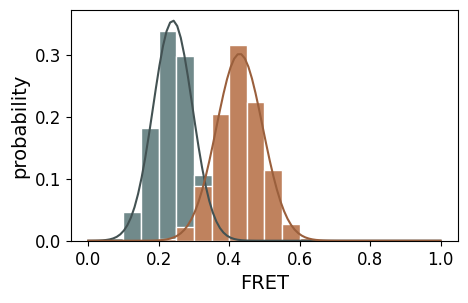

In [20]:
bins = 20

burst_fit_explicit_dyes = burst_fit(burst_explicit_dyes.FRETefficiencies, bins)
burst_fit_macv = burst_fit(burst_macv.FRETefficiencies, bins)


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,3))
ax.hist(burst_explicit_dyes.FRETefficiencies, bins=bins, range=[0,1], color=rgb_to_hex((113, 138, 139)), edgecolor="white", label="explicit dyes", weights=np.ones(len(burst_explicit_dyes.FRETefficiencies))/ len(burst_explicit_dyes.FRETefficiencies))
ax.hist(burst_macv.FRETefficiencies, bins=bins, range=[0,1], color=rgb_to_hex((191, 130, 94)), edgecolor="white", label="explicit dyes", weights=np.ones(len(burst_macv.FRETefficiencies))/ len(burst_macv.FRETefficiencies))
ax.plot(burst_fit_explicit_dyes[0], burst_fit_explicit_dyes[1], color=rgb_to_hex((67, 82, 83)) )
ax.plot(burst_fit_macv[0], burst_fit_macv[1], color=rgb_to_hex((154, 95, 60)) )

ax.set_xlabel("FRET", fontsize=14)
ax.set_ylabel("probability", fontsize=14)
ax.yaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.xaxis.set_major_formatter(FormatStrFormatter("%.1f"))
ax.tick_params(axis='both', labelsize=12)